inspired from: https://www.kaggle.com/aitude/ashrae-kfold-lightgbm-without-leak-1-08

## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
import datetime
import gc

DATA_PATH = "./"

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data

## Utility Functions

In [3]:
# https://www.kaggle.com/nz0722/aligned-timestamp-lgbm-by-meter-type?scriptVersionId=22831732

weather_dtypes = {
    'site_id': np.uint8,
    'air_temperature': np.float32,
    'cloud_coverage': np.float32,
    'dew_temperature': np.float32,
    'precip_depth_1_hr': np.float32,
    'sea_level_pressure': np.float32,
    'wind_direction': np.float32,
    'wind_speed': np.float32,
}


RAW_DATA_DIR = './'
weather_train = pd.read_csv('weather_train.csv',dtype=weather_dtypes, parse_dates=['timestamp'])
weather_test = pd.read_csv('weather_test.csv',dtype=weather_dtypes, parse_dates=['timestamp'])

weather = pd.concat([weather_train,weather_test],ignore_index=True)
del weather_train, weather_test
weather_key = ['site_id', 'timestamp']
temp_skeleton = weather[weather_key + ['air_temperature']].drop_duplicates(subset=weather_key).sort_values(by=weather_key).copy()
del weather

data_to_plot = temp_skeleton.copy()
data_to_plot["hour"] = data_to_plot["timestamp"].dt.hour

# calculate ranks of hourly temperatures within date/site_id chunks
temp_skeleton['temp_rank'] = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.date])['air_temperature'].rank('average')

# create a dataframe of site_ids (0-16) x mean hour rank of temperature within day (0-23)
df_2d = temp_skeleton.groupby(['site_id', temp_skeleton.timestamp.dt.hour])['temp_rank'].mean().unstack(level=1)

# Subtract the columnID of temperature peak by 14, getting the timestamp alignment gap.
site_ids_offsets = pd.Series(df_2d.values.argmax(axis=1) - 14)
site_ids_offsets.index.name = 'site_id'

def timestamp_align(df):
    df['offset'] = df.site_id.map(site_ids_offsets)
    df['timestamp_aligned'] = (pd.to_datetime(df["timestamp"]) - pd.to_timedelta(df.offset, unit='H'))
    df['timestamp'] = df['timestamp_aligned']
    del df['timestamp_aligned']
    return df

In [4]:
# Original code from https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling by @aitude

from meteocalc import Temp, dew_point, heat_index, wind_chill, feels_like

def c2f(T):
    return T * 9 / 5. + 32

def windchill(T, v):
    return (10*v**.5 - v +10.5) * (33 - T)

def prepareweather(df):
    df['RH'] = 100 - 5 * (df['air_temperature']-df['dew_temperature'])
#     df['RH_above50'] = (df['RH'] > 50).astype(int) 
    df['heat'] = df.apply(lambda x: heat_index(c2f(x.air_temperature), x.RH).c, axis=1)
    df['windchill'] = df.apply(lambda x: windchill(x.air_temperature, x.wind_speed), axis=1)
    df['feellike'] = df.apply(lambda x: feels_like(c2f(x.air_temperature), x.RH, x.wind_speed*2.237).c, axis=1)
    
    return df



def add_lag_feature(weather_df, window=3):  
    group_df = weather_df.groupby('site_id')
    cols = ['air_temperature', 'dew_temperature', 'heat', 'windchill', 'feellike']
    rolled = group_df[cols].rolling(window=window, min_periods=0)
    lag_mean = rolled.mean().reset_index().astype(np.float16)
    lag_max = rolled.max().reset_index().astype(np.float16)
    lag_min = rolled.min().reset_index().astype(np.float16)
    lag_std = rolled.std().reset_index().astype(np.float16)
    for col in cols:
        weather_df[f'{col}_mean_lag{window}'] = lag_mean[col]
#         weather_df[f'{col}_max_lag{window}'] = lag_max[col]
#         weather_df[f'{col}_min_lag{window}'] = lag_min[col]
#         weather_df[f'{col}_std_lag{window}'] = lag_std[col]


def fill_weather_dataset(weather_df):
    
    # Find Missing Dates
    time_format = "%Y-%m-%d %H:%M:%S"
    start_date = datetime.datetime.strptime(weather_df['timestamp'].min(),time_format)
    end_date = datetime.datetime.strptime(weather_df['timestamp'].max(),time_format)
    total_hours = int(((end_date - start_date).total_seconds() + 3600) / 3600)
    hours_list = [(end_date - datetime.timedelta(hours=x)).strftime(time_format) for x in range(total_hours)]

    missing_hours = []
    for site_id in range(16):
        site_hours = np.array(weather_df[weather_df['site_id'] == site_id]['timestamp'])
        new_rows = pd.DataFrame(np.setdiff1d(hours_list,site_hours),columns=['timestamp'])
        new_rows['site_id'] = site_id
        weather_df = pd.concat([weather_df,new_rows])

        weather_df = weather_df.reset_index(drop=True) 
        
#     for col in weather_df.columns:
#         if col != 'timestamp':
#             if weather_df[col].isna().sum():
#                 weather_df['na_'+col] = weather_df[col].isna().astype(int)

#     weather_df['weath_na_total'] = weather_df.isna().sum(axis=1)
    
    weather_df = timestamp_align(weather_df)
    # Add new Features
    weather_df["datetime"] = pd.to_datetime(weather_df["timestamp"])
    weather_df["day"] = weather_df["datetime"].dt.day
    weather_df["week"] = weather_df["datetime"].dt.week
    weather_df["month"] = weather_df["datetime"].dt.month
    
    # Reset Index for Fast Update
    weather_df = weather_df.set_index(['site_id','day','month'])

    air_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['air_temperature'].mean(),columns=["air_temperature"])
    weather_df.update(air_temperature_filler,overwrite=False)

    # Step 1
    cloud_coverage_filler = weather_df.groupby(['site_id','day','month'])['cloud_coverage'].mean()
    # Step 2
    cloud_coverage_filler = pd.DataFrame(cloud_coverage_filler.fillna(method='ffill'),columns=["cloud_coverage"])

    weather_df.update(cloud_coverage_filler,overwrite=False)

    due_temperature_filler = pd.DataFrame(weather_df.groupby(['site_id','day','month'])['dew_temperature'].mean(),columns=["dew_temperature"])
    weather_df.update(due_temperature_filler,overwrite=False)

    # Step 1
    sea_level_filler = weather_df.groupby(['site_id','day','month'])['sea_level_pressure'].mean()
    # Step 2
    sea_level_filler = pd.DataFrame(sea_level_filler.fillna(method='ffill'),columns=['sea_level_pressure'])

    weather_df.update(sea_level_filler,overwrite=False)

    wind_direction_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_direction'].mean(),columns=['wind_direction'])
    weather_df.update(wind_direction_filler,overwrite=False)

    wind_speed_filler =  pd.DataFrame(weather_df.groupby(['site_id','day','month'])['wind_speed'].mean(),columns=['wind_speed'])
    weather_df.update(wind_speed_filler,overwrite=False)

    # Step 1
    precip_depth_filler = weather_df.groupby(['site_id','day','month'])['precip_depth_1_hr'].mean()
    # Step 2
    precip_depth_filler = pd.DataFrame(precip_depth_filler.fillna(method='ffill'),columns=['precip_depth_1_hr'])

    weather_df.update(precip_depth_filler,overwrite=False)

    weather_df = weather_df.reset_index()
    weather_df = weather_df.drop(['datetime','day','week','month'],axis=1)

    
    print('add heat, RH...')
    weather_df = prepareweather(weather_df)
    
    print('add lag features')
    add_lag_feature(weather_df, window=3)
    
    return weather_df




# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin

from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """
    Iterate through all the columns of a dataframe and modify the data type to reduce memory usage.        
    """
    
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == "int":
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype("category")

    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))
    print("Decreased by {:.1f}%".format(100 * (start_mem - end_mem) / start_mem))
    
    return df


def features_engineering(df):
    
    # Sort by timestamp
    df.sort_values("timestamp")
    df.reset_index(drop=True)
    
    # Add more features
    df["timestamp"] = pd.to_datetime(df["timestamp"],format="%Y-%m-%d %H:%M:%S")
    df["hour"] = df["timestamp"].dt.hour
    df["weekday"] = df["timestamp"].dt.weekday
    
    # Remove Unused Columns
    drop = ["timestamp","sea_level_pressure", "wind_direction", "wind_speed", "precip_depth_1_hr"]
    df = df.drop(drop, axis=1)
    gc.collect()
    
    return df


def building_features(building_meta_df):
    building_addfeatures = pd.read_feather('building_all_meters.feather')
    
    for col in building_meta_df.columns:
        if col != 'timestamp':
            if building_meta_df[col].isna().sum():
                building_meta_df['na_'+col] = building_meta_df[col].isna().astype(int)

    building_meta_df['build_na_total'] = building_meta_df.isna().sum(axis=1)

    building_meta_df = pd.concat([building_meta_df, 
                                  building_addfeatures[['meter_reading_0', 'meter_reading_1', 
                                                        'meter_reading_2', 'meter_reading_3']]], axis=1)

    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    building_meta_df.primary_use = le.fit_transform(building_meta_df.primary_use)

    building_meta_df['cnt_building_per_site'] = building_meta_df.groupby(['site_id']).building_id.transform(lambda x: x.size)
    building_meta_df['cnt_building_per_site_prim'] = building_meta_df.groupby(['site_id', 'primary_use']).building_id.transform(lambda x: x.size)
    building_meta_df['sqr_mean_per_site'] = building_meta_df.groupby(['site_id', ]).square_feet.transform('median')
    building_meta_df['sqr_mean_per_prim_site'] = building_meta_df.groupby(['site_id', 'primary_use']).square_feet.transform('median')

    return building_meta_df

## Fill Weather Information

I'm using [this kernel](https://www.kaggle.com/aitude/ashrae-missing-weather-data-handling) to handle missing weather information.

In [5]:
train_df = pd.read_feather("./train_cleanup_001.feather")
# train_df = pd.read_csv(DATA_PATH + 'train.csv')

# Remove outliers
train_df = train_df [ train_df['building_id'] != 1099 ]
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')



building_df = pd.read_csv(DATA_PATH + 'building_metadata.csv')
weather_trn = pd.read_csv(DATA_PATH + 'weather_train.csv')
weather_tst = pd.read_csv(DATA_PATH + 'weather_test.csv')
weather_df = pd.concat([weather_trn, weather_tst], axis=0)

In [6]:
train_df.columns

Index(['building_id', 'meter', 'timestamp', 'meter_reading'], dtype='object')

In [7]:
%%time
weather_df = fill_weather_dataset(weather_df)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



add heat, RH...
add lag features
CPU times: user 2min 30s, sys: 1.25 s, total: 2min 32s
Wall time: 2min 31s


In [8]:
building_df = building_features(building_df)

## Merge Data

We need to add building and weather information into training dataset.

In [9]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df.dtypes

building_id               int64
meter                     int64
timestamp        datetime64[ns]
meter_reading           float64
dtype: object

In [10]:
train_df = train_df.merge(building_df, left_on='building_id',right_on='building_id',how='left')
# train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])
train_df = train_df.merge(weather_df,how='left',left_on=['site_id','timestamp'],right_on=['site_id','timestamp'])
del weather_df
gc.collect()

343

## Features Engineering

In [11]:
train_df = features_engineering(train_df)

In [12]:
train_df = reduce_mem_usage(train_df,use_float16=False)
building_df = reduce_mem_usage(building_df,use_float16=False)

Memory usage of dataframe is 4691.48 MB
Memory usage after optimization is: 2064.25 MB
Decreased by 56.0%
Memory usage of dataframe is 0.19 MB
Memory usage after optimization is: 0.06 MB
Decreased by 66.1%


##  KFOLD LIGHTGBM Model

In [13]:
categorical_features = ["building_id", "site_id", "meter", "primary_use", "weekday"]

In [14]:
features0 = ['building_id', 
             'square_feet', 'hour', 'primary_use',
       'weekday', 'year_built', 'heat', 'floor_count', 'feellike',
       'sqr_mean_per_prim_site', 'air_temperature', 
    #'heat_mean_lag3',
       'sqr_mean_per_site', 'dew_temperature_mean_lag3',
       'dew_temperature', 'cnt_building_per_site_prim',
       'feellike_mean_lag3', 'air_temperature_mean_lag3',
       'windchill_mean_lag3', 'cnt_building_per_site', 'windchill',
       'offset', 
       ]

In [15]:
categorical_features0 = [ 'building_id', 'weekday', 'primary_use',]

In [16]:
train_df.columns

Index(['building_id', 'meter', 'meter_reading', 'site_id', 'primary_use',
       'square_feet', 'year_built', 'floor_count', 'na_year_built',
       'na_floor_count', 'build_na_total', 'meter_reading_0',
       'meter_reading_1', 'meter_reading_2', 'meter_reading_3',
       'cnt_building_per_site', 'cnt_building_per_site_prim',
       'sqr_mean_per_site', 'sqr_mean_per_prim_site', 'air_temperature',
       'cloud_coverage', 'dew_temperature', 'offset', 'RH', 'heat',
       'windchill', 'feellike', 'air_temperature_mean_lag3',
       'dew_temperature_mean_lag3', 'heat_mean_lag3', 'windchill_mean_lag3',
       'feellike_mean_lag3', 'hour', 'weekday'],
      dtype='object')

In [17]:
train_df = train_df.reset_index(drop=True)

In [18]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 16,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
    'min_data_in_leaf' : 6000,
}

X_trn = train_df[train_df.meter==0].reset_index(drop=True)
X_trn = X_trn[features0+["meter_reading"]]

target = np.log1p(X_trn["meter_reading"])
X_trn= X_trn.drop('meter_reading', axis = 1)

kf = KFold(n_splits=3)
models0 = []
for train_index,test_index in kf.split(X_trn):
    train_features = X_trn.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = X_trn.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features0, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features0, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models0.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/lightgbm/basic.py:1291: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.755932	valid_1's rmse: 0.780461
[50]	training's rmse: 0.560966	valid_1's rmse: 0.619131
[75]	training's rmse: 0.50147	valid_1's rmse: 0.581353
[100]	training's rmse: 0.475165	valid_1's rmse: 0.569606
[125]	training's rmse: 0.461224	valid_1's rmse: 0.566217
[150]	training's rmse: 0.450564	valid_1's rmse: 0.564193
[175]	training's rmse: 0.442706	valid_1's rmse: 0.562682
[200]	training's rmse: 0.436819	valid_1's rmse: 0.561653
[225]	training's rmse: 0.431703	valid_1's rmse: 0.562871
[250]	training's rmse: 0.427937	valid_1's rmse: 0.562973
Early stopping, best iteration is:
[200]	training's rmse: 0.436819	valid_1's rmse: 0.561653
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 0.760815	valid_1's rmse: 0.812427
[50]	training's rmse: 0.575413	valid_1's rmse: 0.645503
[75]	training's rmse: 0.518516	valid_1's rmse: 0.586647
[100]	training's rmse: 0.49246	valid_1's rmse: 0.556

In [19]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_trn.columns.values
df_fimp_1["importance"] = models0[0].feature_importance()
df_fimp_1["half"] = 1
df_fimp_1.sort_values(by='importance', ascending=False)
df_fimp_1.sort_values(by='importance', ascending=False).feature.values

array(['building_id', 'hour', 'square_feet', 'weekday', 'year_built',
       'heat', 'primary_use', 'floor_count', 'sqr_mean_per_site',
       'feellike', 'cnt_building_per_site', 'dew_temperature', 'offset',
       'dew_temperature_mean_lag3', 'air_temperature',
       'cnt_building_per_site_prim', 'feellike_mean_lag3',
       'sqr_mean_per_prim_site', 'air_temperature_mean_lag3',
       'windchill_mean_lag3', 'windchill'], dtype=object)

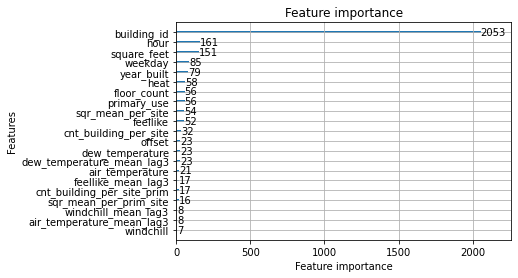

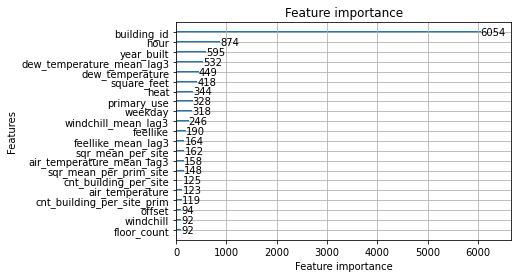

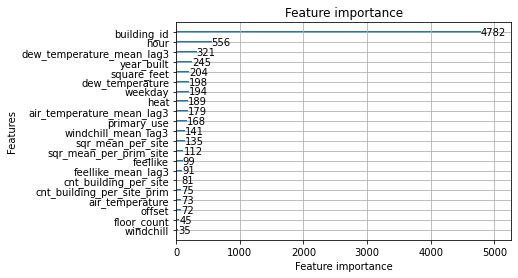

In [20]:
# %matplotlib inline
for model in models0:
    lgb.plot_importance(model)
    plt.show()

# meter =  1

In [21]:
features1 = ['building_id', 'hour', 'square_feet', 'dew_temperature_mean_lag3',
       'dew_temperature', 'weekday', 'windchill_mean_lag3',
       'cloud_coverage', 'heat', 'air_temperature_mean_lag3',
       'year_built', 'RH', 'heat_mean_lag3', 'windchill',
       'cnt_building_per_site_prim', 'air_temperature',
       'cnt_building_per_site', 'feellike_mean_lag3', 'feellike',
       'sqr_mean_per_prim_site', 'primary_use', 'meter_reading_2',
       'sqr_mean_per_site'
       ]

In [22]:
categorical_features1 = ["building_id", "primary_use", "weekday"]

In [23]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

X_trn = train_df[train_df.meter==1].reset_index(drop=True)
X_trn = X_trn[features1+["meter_reading"]]

target = np.log1p(X_trn["meter_reading"])
X_trn= X_trn.drop('meter_reading', axis = 1)

kf = KFold(n_splits=3)
models1 = []
for train_index,test_index in kf.split(X_trn):
    train_features = X_trn.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = X_trn.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features1, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features1, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models1.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.1076	valid_1's rmse: 1.44997
[50]	training's rmse: 0.854728	valid_1's rmse: 1.31341
[75]	training's rmse: 0.780901	valid_1's rmse: 1.30673
[100]	training's rmse: 0.735016	valid_1's rmse: 1.30794
Early stopping, best iteration is:
[73]	training's rmse: 0.785101	valid_1's rmse: 1.30643
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.18049	valid_1's rmse: 1.3235
[50]	training's rmse: 0.927688	valid_1's rmse: 1.15596
[75]	training's rmse: 0.852033	valid_1's rmse: 1.14118
[100]	training's rmse: 0.800864	valid_1's rmse: 1.1401
[125]	training's rmse: 0.766584	valid_1's rmse: 1.14074
Early stopping, best iteration is:
[95]	training's rmse: 0.810055	valid_1's rmse: 1.13955
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.0865	valid_1's rmse: 1.40726
[50]	training's rmse: 0.810255	valid_1's rmse: 1.30846
[75]	training's rmse: 0.733944	valid

In [24]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_trn.columns.values
df_fimp_1["importance"] = models1[0].feature_importance()
df_fimp_1["half"] = 1
df_fimp_1.sort_values(by='importance', ascending=False)
df_fimp_1.sort_values(by='importance', ascending=False).feature[:-10].values

array(['building_id', 'hour', 'dew_temperature_mean_lag3', 'square_feet',
       'dew_temperature', 'weekday', 'air_temperature_mean_lag3', 'heat',
       'cloud_coverage', 'windchill_mean_lag3', 'heat_mean_lag3', 'RH',
       'windchill'], dtype=object)

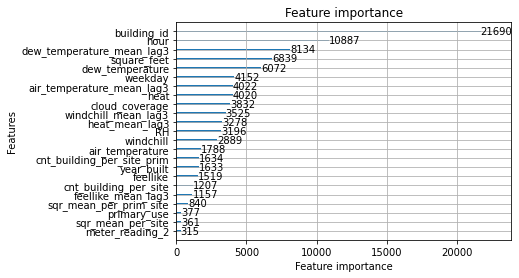

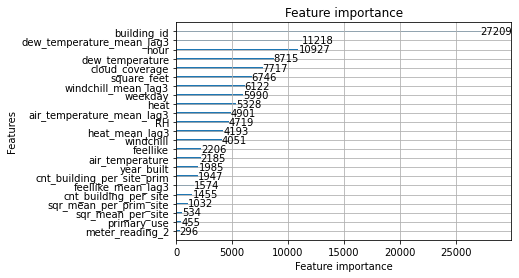

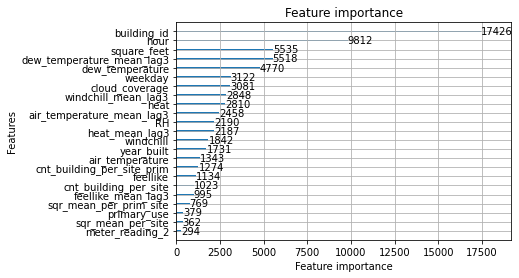

In [25]:
# %matplotlib inline
for model in models1:
    lgb.plot_importance(model)
    plt.show()

# meter == 2

In [26]:
features2 = ['building_id', 'hour', 'square_feet', 'dew_temperature_mean_lag3',
       'dew_temperature', 'heat', 'windchill_mean_lag3', 'cloud_coverage',
       'RH', 'windchill', 'weekday', 'air_temperature_mean_lag3',
       'heat_mean_lag3', 'air_temperature', 'cnt_building_per_site_prim',
       'feellike', 'feellike_mean_lag3', 'cnt_building_per_site',
       'year_built', 'sqr_mean_per_prim_site', 'meter_reading_1', 'site_id',
       'primary_use',
       ]

In [27]:
categorical_features2 = ["building_id", "site_id", "primary_use", "weekday"]

In [28]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

X_trn = train_df[train_df.meter==2].reset_index(drop=True)
X_trn = X_trn[features2+["meter_reading"]]

target = np.log1p(X_trn["meter_reading"])
X_trn= X_trn.drop('meter_reading', axis = 1)

kf = KFold(n_splits=3)
models2 = []
for train_index,test_index in kf.split(X_trn):
    train_features = X_trn.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = X_trn.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features2, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features2, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models2.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.21795	valid_1's rmse: 1.53802
[50]	training's rmse: 0.980962	valid_1's rmse: 1.48238
[75]	training's rmse: 0.920918	valid_1's rmse: 1.49239
Early stopping, best iteration is:
[44]	training's rmse: 1.00829	valid_1's rmse: 1.48154
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.19409	valid_1's rmse: 1.52262
[50]	training's rmse: 0.959692	valid_1's rmse: 1.34135
[75]	training's rmse: 0.884457	valid_1's rmse: 1.31654
[100]	training's rmse: 0.838463	valid_1's rmse: 1.31064
[125]	training's rmse: 0.8057	valid_1's rmse: 1.30886
[150]	training's rmse: 0.778926	valid_1's rmse: 1.30992
Early stopping, best iteration is:
[123]	training's rmse: 0.808344	valid_1's rmse: 1.30872
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.17903	valid_1's rmse: 1.51747
[50]	training's rmse: 0.93056	valid_1's rmse: 1.45643
[75]	training's rmse: 0.870645	vali

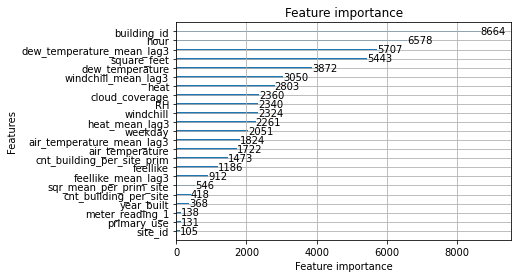

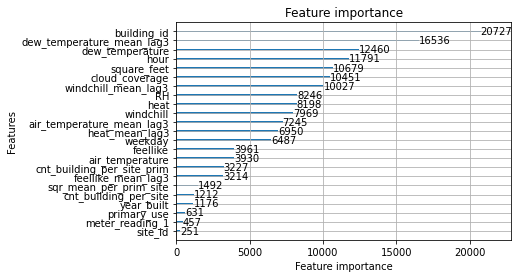

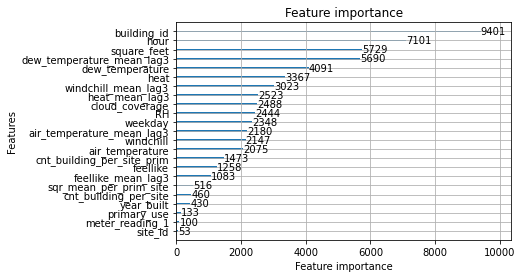

In [29]:
# %matplotlib inline
for model in models2:
    lgb.plot_importance(model)
    plt.show()

In [30]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_trn.columns.values
df_fimp_1["importance"] = models2[0].feature_importance()
df_fimp_1["half"] = 1
df_fimp_1.sort_values(by='importance', ascending=False)
df_fimp_1.sort_values(by='importance', ascending=False).feature.values

array(['building_id', 'hour', 'dew_temperature_mean_lag3', 'square_feet',
       'dew_temperature', 'windchill_mean_lag3', 'heat', 'cloud_coverage',
       'RH', 'windchill', 'heat_mean_lag3', 'weekday',
       'air_temperature_mean_lag3', 'air_temperature',
       'cnt_building_per_site_prim', 'feellike', 'feellike_mean_lag3',
       'sqr_mean_per_prim_site', 'cnt_building_per_site', 'year_built',
       'meter_reading_1', 'primary_use', 'site_id'], dtype=object)

# meter == 3

In [31]:
features3 = ['dew_temperature_mean_lag3', 'hour', 'dew_temperature',
       'building_id', 'square_feet', 'windchill_mean_lag3', 'RH',
       'air_temperature_mean_lag3', 'heat', 'cloud_coverage', 'windchill',
       'heat_mean_lag3', 'air_temperature', 'weekday',
       'feellike_mean_lag3', 'feellike', 'year_built',
       'cnt_building_per_site_prim', 'sqr_mean_per_prim_site',
       'floor_count', 'cnt_building_per_site', 'build_na_total',
       'meter_reading_2'
       ]

In [32]:
categorical_features3 = ["building_id", "weekday"]

In [33]:
params = {
    "objective": "regression",
    "boosting": "gbdt",
    "num_leaves": 1280,
    "learning_rate": 0.05,
    "feature_fraction": 0.85,
    "reg_lambda": 2,
    "metric": "rmse",
}

X_trn = train_df[train_df.meter==3].reset_index(drop=True)
X_trn = X_trn[features3+["meter_reading"]]

target = np.log1p(X_trn["meter_reading"])
X_trn= X_trn.drop('meter_reading', axis = 1)

kf = KFold(n_splits=3)
models3 = []
for train_index,test_index in kf.split(X_trn):
    train_features = X_trn.loc[train_index]
    train_target = target.loc[train_index]
    
    test_features = X_trn.loc[test_index]
    test_target = target.loc[test_index]
    
    d_training = lgb.Dataset(train_features, label=train_target,categorical_feature=categorical_features3, free_raw_data=False)
    d_test = lgb.Dataset(test_features, label=test_target,categorical_feature=categorical_features3, free_raw_data=False)
    
    model = lgb.train(params, train_set=d_training, num_boost_round=1000, valid_sets=[d_training,d_test], verbose_eval=25, early_stopping_rounds=50)
    models3.append(model)
    del train_features, train_target, test_features, test_target, d_training, d_test
    gc.collect()

Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.30776	valid_1's rmse: 1.71328
[50]	training's rmse: 1.06651	valid_1's rmse: 1.64455
[75]	training's rmse: 0.987217	valid_1's rmse: 1.65236
Early stopping, best iteration is:
[47]	training's rmse: 1.08088	valid_1's rmse: 1.64438
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.37921	valid_1's rmse: 1.50667
[50]	training's rmse: 1.15188	valid_1's rmse: 1.36951
[75]	training's rmse: 1.06688	valid_1's rmse: 1.36146
[100]	training's rmse: 1.01205	valid_1's rmse: 1.36194
Early stopping, best iteration is:
[70]	training's rmse: 1.08024	valid_1's rmse: 1.36067
Training until validation scores don't improve for 50 rounds
[25]	training's rmse: 1.2557	valid_1's rmse: 1.71163
[50]	training's rmse: 0.998466	valid_1's rmse: 1.65278
[75]	training's rmse: 0.919643	valid_1's rmse: 1.66163
Early stopping, best iteration is:
[47]	training's rmse: 1.01289	valid_1's rmse: 1.6527


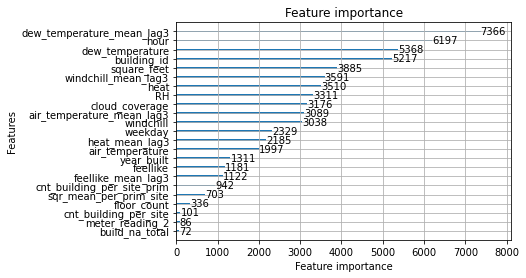

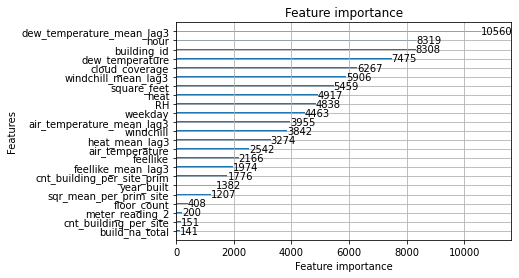

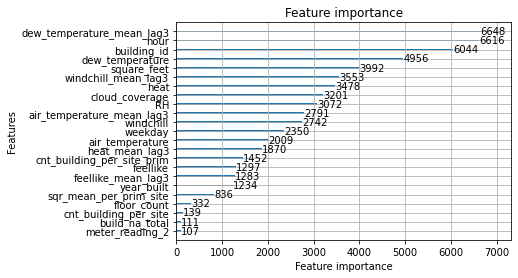

In [34]:
# %matplotlib inline
for model in models3:
    lgb.plot_importance(model)
    plt.show()

In [35]:
df_fimp_1 = pd.DataFrame()
df_fimp_1["feature"] = X_trn.columns.values
df_fimp_1["importance"] = models3[0].feature_importance()
df_fimp_1["half"] = 1
df_fimp_1.sort_values(by='importance', ascending=False)
df_fimp_1.sort_values(by='importance', ascending=False).feature[:-10].values

array(['dew_temperature_mean_lag3', 'hour', 'dew_temperature',
       'building_id', 'square_feet', 'windchill_mean_lag3', 'heat', 'RH',
       'cloud_coverage', 'air_temperature_mean_lag3', 'windchill',
       'weekday', 'heat_mean_lag3'], dtype=object)

## Load Test Data

In [36]:
test_df = pd.read_csv('test.csv')
row_ids = test_df["row_id"]
test_df.drop("row_id", axis=1, inplace=True)
#test_df = reduce_mem_usage(test_df)

## Merge Building Data

In [37]:
test_df = test_df.merge(building_df,left_on='building_id',right_on='building_id',how='left')
del building_df
gc.collect()

18416

## Fill Weather Information

In [38]:
weather_df = pd.read_csv('weather_test.csv')
weather_df = fill_weather_dataset(weather_df)
# weather_df = reduce_mem_usage(weather_df)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:51: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



add heat, RH...
add lag features


## Merge Weather Data

In [39]:
#test_df["timestamp"] = pd.to_datetime(test_df["timestamp"].astype('float'))

In [40]:
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])
test_df = test_df.merge(weather_df,how='left',on=['timestamp','site_id'])
del weather_df
gc.collect()

364

## Features Engineering

In [41]:
test_df = features_engineering(test_df)

## Prediction

In [42]:
featuress = [features0, features1, features2, features3]

In [43]:
def create_X(test_df, target_meter):
    target_test_df = test_df[test_df['meter'] == target_meter]
    target_test_df = target_test_df[featuress[target_meter]]
    return target_test_df

In [44]:
from tqdm import tqdm_notebook as tqdm

def pred(X_test, models, batch_size=1000000):
    iterations = (X_test.shape[0] + batch_size -1) // batch_size
    print('iterations', iterations)

    y_test_pred_total = np.zeros(X_test.shape[0])
    for i, model in enumerate(models):
        print(f'predicting {i}-th model')
        for k in tqdm(range(iterations)):
            y_pred_test = model.predict(X_test[k*batch_size:(k+1)*batch_size], num_iteration=model.best_iteration)
            y_test_pred_total[k*batch_size:(k+1)*batch_size] += y_pred_test

    y_test_pred_total /= len(models)
    return y_test_pred_total

iterations 25
predicting 0-th model


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



predicting 1-th model



predicting 2-th model



CPU times: user 1h 9min 11s, sys: 22.2 s, total: 1h 9min 34s
Wall time: 4min 44s


44

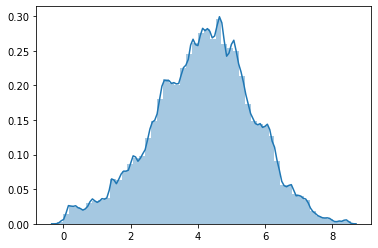

In [45]:
%%time

X_test = create_X(test_df, target_meter=0)
gc.collect()

y_test0 = pred(X_test, models0)

sns.distplot(y_test0)

del X_test
gc.collect()

iterations 9
predicting 0-th model


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



predicting 1-th model



predicting 2-th model



CPU times: user 10min 42s, sys: 8.08 s, total: 10min 50s
Wall time: 49 s


23

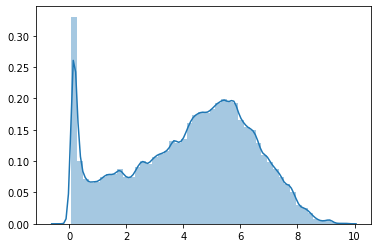

In [46]:
%%time

X_test = create_X(test_df, target_meter=1)
gc.collect()

y_test1 = pred(X_test, models1)

sns.distplot(y_test1)

del X_test
gc.collect()

iterations 6
predicting 0-th model


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



predicting 1-th model



predicting 2-th model



CPU times: user 6min 17s, sys: 5.09 s, total: 6min 22s
Wall time: 29.1 s


30

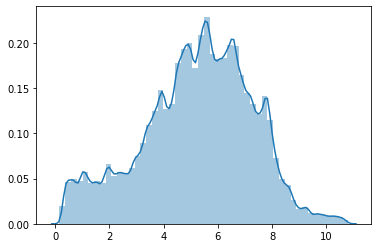

In [47]:
%%time

X_test = create_X(test_df, target_meter=2)
gc.collect()

y_test2 = pred(X_test, models2)

sns.distplot(y_test2)

del X_test
gc.collect()

iterations 3
predicting 0-th model


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:10: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # Remove the CWD from sys.path while we load stuff.



predicting 1-th model



predicting 2-th model



CPU times: user 1min 55s, sys: 2.32 s, total: 1min 57s
Wall time: 9.4 s


17

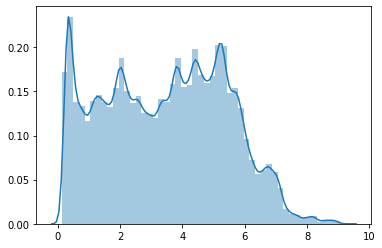

In [48]:
%%time

X_test = create_X(test_df, target_meter=3)
gc.collect()

y_test3 = pred(X_test, models3)

sns.distplot(y_test3)

del X_test
gc.collect()

In [49]:
sample_submission = pd.read_csv('sample_submission.csv')

In [50]:
sample_submission.loc[test_df['meter'] == 0, 'meter_reading'] = np.expm1(y_test0)
sample_submission.loc[test_df['meter'] == 1, 'meter_reading'] = np.expm1(y_test1)
sample_submission.loc[test_df['meter'] == 2, 'meter_reading'] = np.expm1(y_test2)
sample_submission.loc[test_df['meter'] == 3, 'meter_reading'] = np.expm1(y_test3)

In [51]:
sample_submission.to_csv('submission_multimeter003.csv.gz',
                         index=False,compression='gzip', 
                         float_format='%.4f', 
                         chunksize=25000)

In [52]:
#!kaggle competitions submit -c ashrae-energy-prediction -f submission_multimeter003.csv.gz -m "submission_multimeter003"